In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder

In [2]:
train_set = pd.read_csv('Datasets/train.csv')

train_set.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent
0,2021-09,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900
3,2021-08,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850
4,2022-11,kallang/whampoa,34,Whampoa West,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100


### data cleaning

In [3]:
# get copy

train_set_cleaned = train_set.copy()

In [4]:
# add two new attributes, split rent_approval_date into month, year

train_set_cleaned[['rent_approval_year','rent_approval_month']] = train_set_cleaned['rent_approval_date'].str.split('-',expand=True)

# train_set_cleaned['rent_approval_month'] = pd.to_datetime(train_set_cleaned['rent_approval_month'], format='%m').dt.month
# train_set_cleaned['rent_approval_year'] = pd.to_datetime(train_set_cleaned['rent_approval_year'], format='%y').dt.year

In [5]:
# street name to lower case

train_set_cleaned['street_name'] = train_set_cleaned['street_name'].apply(str.lower)

In [6]:
# replace blank space with hyphen in flat_type (e.g. '2 room' to '2-room')

train_set_cleaned['flat_type'] = train_set_cleaned['flat_type'].apply(lambda x: x.replace(' ', '-'))

In [7]:
def date_filter_condition(x):
    
    if x < 1970:
        return 'before 70s'
    elif x >= 1970 and x < 1980:
        return '70s'
    elif x >= 1980 and x < 1990:
        return '80s'
    elif x >= 1990 and x < 2000:
        return '90s'
    elif x >= 2000 and x < 2010:
        return '00s'
    elif x >= 2010 and x < 2020:
        return '10s'
    else:
        return 'others'

# categorize lease commence date by decades    
train_set_cleaned['lease_date_cat'] = train_set_cleaned['lease_commence_date'].apply(date_filter_condition)

In [8]:
train_set_cleaned.head(10)

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,monthly_rent,rent_approval_year,rent_approval_month,lease_date_cat
0,2021-09,jurong east,257,jurong east street 24,3-room,new generation,67.0,yes,1983,1.344518,103.738630,0.0,yuhua east,jurong east,west region,1600,2021,09,80s
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,1.330186,103.938717,0.0,bedok north,bedok,east region,2250,2022,05,70s
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,1.332242,103.845643,0.0,toa payoh central,toa payoh,central region,1900,2022,10,70s
3,2021-08,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,1993,1.370239,103.962894,0.0,pasir ris drive,pasir ris,east region,2850,2021,08,90s
4,2022-11,kallang/whampoa,34,whampoa west,3-room,improved,68.0,yes,1972,1.320502,103.863341,0.0,bendemeer,kallang,central region,2100,2022,11,70s
5,2023-04,bukit panjang,654,senja road,executive,premium apartment,130.0,yes,2001,1.387847,103.764249,0.0,saujana,bukit panjang,west region,2300,2023,04,00s
6,2021-01,sengkang,407b,fernvale road,5-room,premium apartment,110.0,yes,2005,1.388997,103.875148,0.0,fernvale,sengkang,north-east region,2100,2021,01,00s
7,2022-06,ang mo kio,223,ang mo kio avenue 1,3-room,new generation,67.0,yes,1978,1.366048,103.838123,0.0,shangri-la,ang mo kio,north-east region,2300,2022,06,70s
8,2021-10,bishan,149,bishan street 11,4-room,simplified,84.0,yes,1987,1.344279,103.855556,0.0,bishan east,bishan,central region,2100,2021,10,80s
9,2021-04,punggol,133,edgedale plains,5-room,premium apartment,112.0,yes,2003,1.392832,103.910620,0.0,punggol field,punggol,north-east region,2100,2021,04,00s


In [9]:
train_set_cleaned['rent_approval_year'].value_counts()

2021    24909
2022    21399
2023    13692
Name: rent_approval_year, dtype: int64

### auxiliary data

In [10]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in km
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance


In [11]:
def calculate_distance_to_facilities(data):
    existing_mrt_df = pd.read_csv('Datasets/auxiliary-data/sg-mrt-existing-stations.csv')
    shopping_malls_df = pd.read_csv('Datasets/auxiliary-data/sg-shopping-malls.csv')
    primary_schools_df = pd.read_csv('Datasets/auxiliary-data/sg-primary-schools.csv')

    # Calculate distances to existing MRT stations
    property_latitudes = data['latitude'].values
    property_longitudes = data['longitude'].values
    existing_mrt_latitudes = existing_mrt_df['latitude'].values
    existing_mrt_longitudes = existing_mrt_df['longitude'].values
    shopping_malls_latitudes = shopping_malls_df['latitude'].values
    shopping_malls_longitudes = shopping_malls_df['longitude'].values
    primary_schools_latitudes = primary_schools_df['latitude'].values
    primary_schools_longitudes = primary_schools_df['longitude'].values
    # planned_mrt_latitudes = planned_mrt_df['latitude'].values
    # planned_mrt_longitudes = planned_mrt_df['longitude'].values

    # Calculate distances
    distances_to_existing_mrt = haversine(
        property_latitudes[:, np.newaxis], property_longitudes[:, np.newaxis],
        existing_mrt_latitudes, existing_mrt_longitudes
    )

    distances_to_shopping_malls = haversine(
        property_latitudes[:, np.newaxis], property_longitudes[:, np.newaxis],
        shopping_malls_latitudes, shopping_malls_longitudes
    )

    distances_to_primary_schools = haversine(
        property_latitudes[:, np.newaxis], property_longitudes[:, np.newaxis],
        primary_schools_latitudes, primary_schools_longitudes
    )

    # distances_to_planned_mrt = haversine(
    #     property_latitudes[:, np.newaxis], property_longitudes[:, np.newaxis],
    #     planned_mrt_latitudes, planned_mrt_longitudes
    # )

    # Find the minimum distances
    min_distances_to_existing_mrt = np.min(distances_to_existing_mrt, axis=1)
    min_distances_to_shopping_mall = np.min(distances_to_shopping_malls, axis=1)
    min_distances_to_primary_school = np.min(distances_to_primary_schools, axis=1)

    # Add the minimum distance as new features 'distance_to_nearest_existing_mrt', 'distance_to_nearest_shopping_mall', 'distance_to_nearest_primary_school'
    data['distance_to_nearest_existing_mrt'] = min_distances_to_existing_mrt
    data['distance_to_nearest_shopping_mall'] = min_distances_to_shopping_mall
    data['distance_to_nearest_primary_school'] = min_distances_to_primary_school
    
    data.drop(columns=['latitude', 'longitude'], inplace=True)

    data.head()
    return data

In [12]:
train_set_cleaned = calculate_distance_to_facilities(train_set_cleaned)
train_set_cleaned.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,elevation,subzone,planning_area,region,monthly_rent,rent_approval_year,rent_approval_month,lease_date_cat,distance_to_nearest_existing_mrt,distance_to_nearest_shopping_mall,distance_to_nearest_primary_school
0,2021-09,jurong east,257,jurong east street 24,3-room,new generation,67.0,yes,1983,0.0,yuhua east,jurong east,west region,1600,2021,09,80s,0.699127,1.202674,0.334846
1,2022-05,bedok,119,bedok north road,4-room,new generation,92.0,yes,1978,0.0,bedok north,bedok,east region,2250,2022,05,70s,0.898991,1.114338,0.607716
2,2022-10,toa payoh,157,lorong 1 toa payoh,3-room,improved,67.0,yes,1971,0.0,toa payoh central,toa payoh,central region,1900,2022,10,70s,0.218603,0.468297,0.425760
3,2021-08,pasir ris,250,pasir ris street 21,executive,apartment,149.0,yes,1993,0.0,pasir ris drive,pasir ris,east region,2850,2021,08,90s,1.546040,0.402359,0.564969
4,2022-11,kallang/whampoa,34,whampoa west,3-room,improved,68.0,yes,1972,0.0,bendemeer,kallang,central region,2100,2022,11,70s,0.187856,1.073354,0.271723


### encoding

In [13]:
# create a new dataframe
encoded_train_set = train_set_cleaned[['monthly_rent']].copy()

#### spatial information

In [14]:
# encode regions with the mean of target variable for each region

region_encoder = TargetEncoder()
encoded_train_set['region_encoded'] = region_encoder.fit_transform(train_set_cleaned['region'], train_set_cleaned['monthly_rent'])

In [15]:
# encode planning areas with target variable information

planning_area_encoder = TargetEncoder()
encoded_train_set['planning_area_encoded'] = planning_area_encoder.fit_transform(train_set_cleaned['planning_area'], train_set_cleaned['monthly_rent'])

In [16]:
# encode subzones with target variable information

subzone_encoder = TargetEncoder()
encoded_train_set['subzone_encoded'] = subzone_encoder.fit_transform(train_set_cleaned['subzone'], train_set_cleaned['monthly_rent'])

In [17]:
# encode streets with target variable information

street_encoder = TargetEncoder()
encoded_train_set['street_encoded'] = street_encoder.fit_transform(train_set_cleaned['street_name'], train_set_cleaned['monthly_rent'])

In [18]:
## encode block (with street name) with target variable information

block_encoder = TargetEncoder()
encoded_train_set['block_encoded'] = block_encoder.fit_transform(train_set_cleaned['street_name']+train_set_cleaned['block'], train_set_cleaned['monthly_rent'])

In [19]:
# spatial hierarchical correlation

region_planning_corr = encoded_train_set['region_encoded'].corr(encoded_train_set['planning_area_encoded'])
planning_subzone_corr = encoded_train_set['planning_area_encoded'].corr(encoded_train_set['subzone_encoded'])
subzone_street_corr = encoded_train_set['subzone_encoded'].corr(encoded_train_set['street_encoded'])

print(f'The correlation between region and planning area is {region_planning_corr:3f}')
print(f'The correlation between planning area and subzone is {planning_subzone_corr:3f}')
print(f'The correlation between subzone and street is {subzone_street_corr:3f}')

The correlation between region and planning area is 0.579100
The correlation between planning area and subzone is 0.669665
The correlation between subzone and street is 0.828036


In [20]:
# spatial information correlation with monthly rent

region_rent_corr = encoded_train_set['region_encoded'].corr(encoded_train_set['monthly_rent'])
planning_rent_corr = encoded_train_set['planning_area_encoded'].corr(encoded_train_set['monthly_rent'])
subzone_rent_corr = encoded_train_set['subzone_encoded'].corr(encoded_train_set['monthly_rent'])
street_rent_corr = encoded_train_set['street_encoded'].corr(encoded_train_set['monthly_rent'])
block_rent_corr = encoded_train_set['block_encoded'].corr(encoded_train_set['monthly_rent'])

print(f'Region and Monthly Rental correlation is {region_rent_corr:3f}')
print(f'Planning Area and Monthly Rental correlation is {planning_rent_corr:3f}')
print(f'Subzone and Monthly Rental correlation is {subzone_rent_corr:3f}')
print(f'Street and Monthly Rental correlation is {street_rent_corr:3f}')
print(f'Block and Monthly Rental correlation is {block_rent_corr:3f}')

Region and Monthly Rental correlation is 0.124776
Planning Area and Monthly Rental correlation is 0.215462
Subzone and Monthly Rental correlation is 0.320711
Street and Monthly Rental correlation is 0.374731
Block and Monthly Rental correlation is 0.521544


#### rent date & lease date

In [21]:
# rental approval date

rental_encoder = TargetEncoder()
encoded_train_set['rental_approval_date_encoded'] = rental_encoder.fit_transform(train_set_cleaned['rent_approval_date'].astype(str), train_set_cleaned['monthly_rent'])

rental_date_rent_corr = encoded_train_set['rental_approval_date_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Rental Approval Date and Monthly Rental correlation is {rental_date_rent_corr:3f}')

Rental Approval Date and Monthly Rental correlation is 0.546074


In [22]:
# rental approval year

rental_year_encoder = TargetEncoder()
encoded_train_set['rental_approval_year_encoded'] = rental_year_encoder.fit_transform(train_set_cleaned['rent_approval_year'].astype(str), train_set_cleaned['monthly_rent'])

rental_year_rent_corr = encoded_train_set['rental_approval_year_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Rental Approval Year and Monthly Rental correlation is {rental_year_rent_corr:3f}')

Rental Approval Year and Monthly Rental correlation is 0.504737


In [23]:
# rental approval month

rental_month_encoder = TargetEncoder()
encoded_train_set['rental_approval_month_encoded'] = rental_month_encoder.fit_transform(train_set_cleaned['rent_approval_month'].astype(str), train_set_cleaned['monthly_rent'])

rental_month_rent_corr = encoded_train_set['rental_approval_month_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Rental Approval Month and Monthly Rental correlation is {rental_month_rent_corr:3f}')

Rental Approval Month and Monthly Rental correlation is 0.106482


In [24]:
# lease commence year (in decade)

lease_encoder = TargetEncoder()
encoded_train_set['lease_commence_date_encoded'] = lease_encoder.fit_transform(train_set_cleaned['lease_date_cat'], train_set_cleaned['monthly_rent'])

lease_date_rent_corr = encoded_train_set['lease_commence_date_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Lease Commence Date and Monthly Rental correlation is {lease_date_rent_corr:3f}')

Lease Commence Date and Monthly Rental correlation is 0.223300


In [25]:
## rental date + type (NOT good for GBR)

type_by_date = TargetEncoder()
encoded_train_set['type_by_date_encoded'] = type_by_date.fit_transform(train_set_cleaned['rent_approval_date']+train_set_cleaned['flat_type'], train_set_cleaned['monthly_rent'])

type_by_date_rent_corr = encoded_train_set['type_by_date_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Flat Type by Rental Date and Monthly Rental correlation is {type_by_date_rent_corr:3f}')

Flat Type by Rental Date and Monthly Rental correlation is 0.655330


#### flat_type and flat_model

In [26]:
train_set_cleaned['flat_type'].value_counts()

4-room       21889
3-room       18897
5-room       14759
executive     3528
2-room         927
Name: flat_type, dtype: int64

In [27]:
# flat type

flat_type_encoder = TargetEncoder()
encoded_train_set['flat_type_encoded'] = flat_type_encoder.fit_transform(train_set_cleaned['flat_type'], train_set_cleaned['monthly_rent'])

flat_type_rent_corr = encoded_train_set['flat_type_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Flat Type and Monthly Rental correlation is {flat_type_rent_corr:3f}')

Flat Type and Monthly Rental correlation is 0.346146


In [28]:
# flat model

flat_model_encoder = TargetEncoder()
encoded_train_set['flat_model_encoded'] = flat_model_encoder.fit_transform(train_set_cleaned['flat_model'], train_set_cleaned['monthly_rent'])

flat_model_rent_corr = encoded_train_set['flat_model_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Flat Model and Monthly Rental correlation is {flat_model_rent_corr:3f}')

Flat Model and Monthly Rental correlation is 0.236876


In [29]:
## street + type

type_by_street = TargetEncoder()
encoded_train_set['type_by_street_encoded'] = type_by_street.fit_transform(train_set_cleaned['street_name']+train_set_cleaned['flat_type'], train_set_cleaned['monthly_rent'])

type_by_street_rent_corr = encoded_train_set['type_by_street_encoded'].corr(encoded_train_set['monthly_rent'])
print(f'Flat Type by Street and Monthly Rental correlation is {type_by_street_rent_corr:3f}')

Flat Type by Street and Monthly Rental correlation is 0.481737


#### floor area

In [30]:
# floor area sqm
encoded_train_set['floor_area_sqm'] = train_set_cleaned['floor_area_sqm'].copy()

floor_area_sqm_corr = encoded_train_set['floor_area_sqm'].corr(encoded_train_set['monthly_rent'])
print(f'Floor Area in Sqm and Monthly Rental correlation is {floor_area_sqm_corr:3f}')

Floor Area in Sqm and Monthly Rental correlation is 0.306466


#### Distance to facilities

In [31]:
# distance to nearest mrt
encoded_train_set['distance_to_nearest_existing_mrt'] = train_set_cleaned['distance_to_nearest_existing_mrt'].copy()

distance_to_nearest_mrt_rent_corr = encoded_train_set['distance_to_nearest_existing_mrt'].corr(encoded_train_set['monthly_rent'])
print(f'Distance to nearest mrt and Monthly Rental correlation is {distance_to_nearest_mrt_rent_corr:3f}')

Distance to nearest mrt and Monthly Rental correlation is -0.067058


In [32]:
# distance to nearest shopping mall
encoded_train_set['distance_to_nearest_shopping_mall'] = train_set_cleaned['distance_to_nearest_shopping_mall'].copy()

distance_to_nearest_shopping_mall_rent_corr = encoded_train_set['distance_to_nearest_shopping_mall'].corr(encoded_train_set['monthly_rent'])
print(f'Distance to nearest shopping mall and Monthly Rental correlation is {distance_to_nearest_shopping_mall_rent_corr:3f}')

Distance to nearest shopping mall and Monthly Rental correlation is -0.071104


In [33]:
# distance to nearest primary school
encoded_train_set['distance_to_nearest_primary_school'] = train_set_cleaned['distance_to_nearest_primary_school'].copy()

distance_to_nearest_primary_school_rent_corr = encoded_train_set['distance_to_nearest_primary_school'].corr(encoded_train_set['monthly_rent'])
print(f'Distance to nearest primary school and Monthly Rental correlation is {distance_to_nearest_primary_school_rent_corr:3f}')

Distance to nearest primary school and Monthly Rental correlation is 0.001750


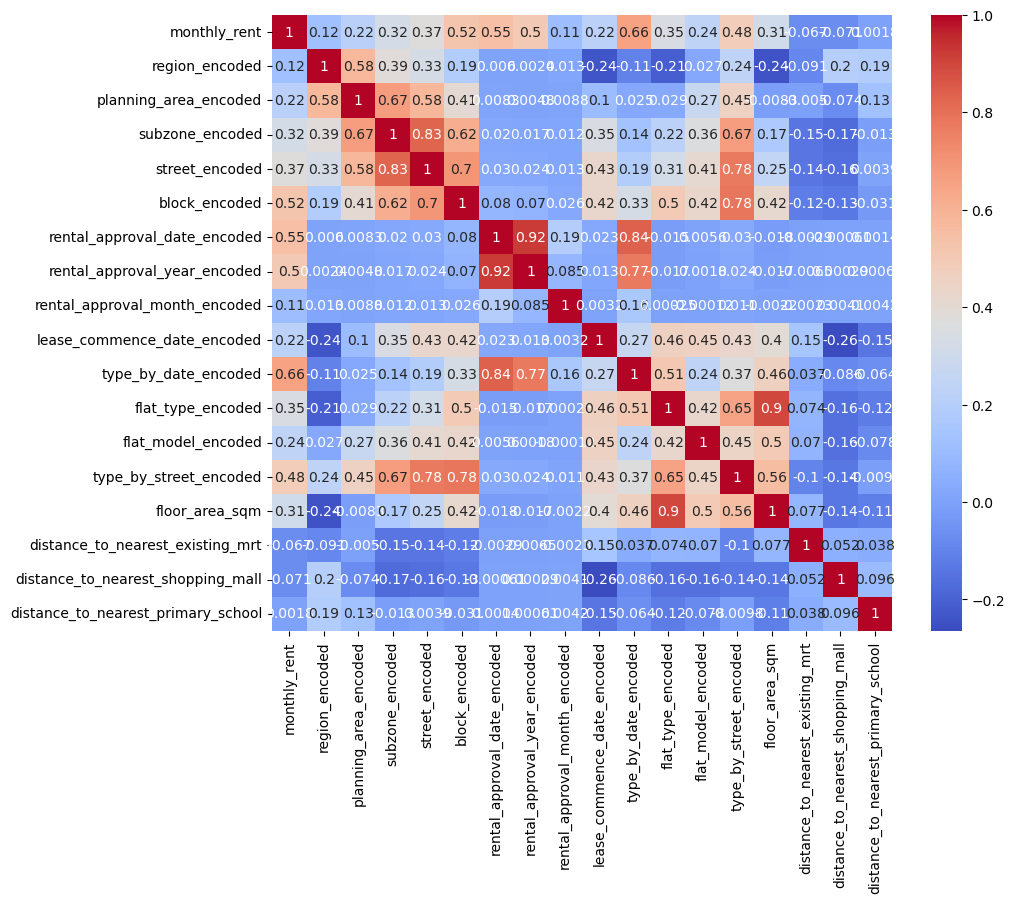

In [34]:
corr = encoded_train_set.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()

### normalization

In [35]:
from sklearn.preprocessing import StandardScaler

In [36]:
encoded_train_set

,monthly_rent,region_encoded,planning_area_encoded,subzone_encoded,street_encoded,block_encoded,rental_approval_date_encoded,rental_approval_year_encoded,rental_approval_month_encoded,lease_commence_date_encoded,type_by_date_encoded,flat_type_encoded,flat_model_encoded,type_by_street_encoded,floor_area_sqm,distance_to_nearest_existing_mrt,distance_to_nearest_shopping_mall,distance_to_nearest_primary_school
0,1600,2569.167537,2595.146199,2542.158516,2312.179832,2319.910527,2233.926780,2225.773817,2489.108495,2479.803864,1971.702454,2276.033233,2369.965462,2237.215820,67.0,0.699127,1.202674,0.334846
1,2250,2570.667785,2438.227223,2360.371046,2404.212860,2596.971112,2517.128874,2651.014066,2618.130520,2421.705462,2611.061286,2692.359176,2369.965462,2591.822430,92.0,0.898991,1.114338,0.607716
2,1900,2737.201353,2516.680515,2808.893871,2403.464419,2317.549823,2928.483245,2651.014066,2563.328013,2421.705462,2523.925781,2276.033233,2636.211052,2301.216814,67.0,0.218603,0.468297,0.425760
3,2850,2570.667785,2686.857477,2610.338573,2757.834101,2678.043573,2249.901768,2225.773817,2470.895522,2700.899570,2500.002036,2892.857143,2878.725962,2840.416063,149.0,1.546040,0.402359,0.564969
4,2100,2737.201353,2702.635659,2793.525180,2407.998266,2407.998266,2986.739659,2651.014066,2611.993243,2421.705462,2615.208748,2276.033233,2636.211052,2407.998266,68.0,0.187856,1.073354,0.271723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2200,2558.822710,2416.700057,2390.887097,2336.012658,2549.933369,2233.926780,2225.773817,2489.108495,2421.705462,1971.702454,2276.033233,2369.965462,2206.830123,67.0,0.670095,0.949719,0.360651
59996,4100,2737.201353,2904.113924,2694.936709,2763.731680,2784.903851,3178.128128,3158.694858,2608.904470,2880.707364,3309.905020,2692.359176,2612.031305,2745.330132,83.0,0.619569,0.740674,0.562691
59997,2250,2570.667785,2638.489123,2602.823315,2509.602223,2651.586378,2582.606383,2651.014066,2658.595055,2479.803864,2801.307190,2815.593875,2636.211052,2541.557159,122.0,0.722926,0.439795,0.320031
59998,4700,2570.667785,2438.227223,2434.379786,2591.443246,2766.882904,3069.581639,3158.694858,2490.553580,2421.705462,3427.662037,2815.593875,2444.223986,2743.101626,123.0,0.923539,1.775198,0.219549


In [37]:
# initialize the feature scaler
scaler = StandardScaler()

normalized_features = scaler.fit_transform(encoded_train_set.iloc[:,1:])

In [38]:
df_describe = pd.DataFrame(normalized_features)
df_describe.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04,6.000000e+04
mean,3.504271e-15,3.138378e-15,1.884108e-15,-1.100081e-15,2.279641e-15,8.512080e-16,-2.717411e-15,-7.782885e-16,1.624649e-15,9.484460e-16,6.510163e-16,1.377269e-16,8.100779e-16,4.176437e-16,3.547949e-16,-3.962256e-16,-3.192853e-16
std,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00
min,-1.566138e+00,-1.248074e+00,-1.997123e+00,-2.296490e+00,-4.021880e+00,-1.136227e+00,-1.010297e+00,-1.568908e+00,-2.255897e+00,-1.887184e+00,-2.991037e+00,-3.995729e+00,-3.135778e+00,-2.511392e+00,-1.635873e+00,-1.753767e+00,-1.538429e+00
25%,-3.531893e-01,-8.052347e-01,-6.691684e-01,-6.786320e-01,-5.535625e-01,-8.720157e-01,-1.010297e+00,-6.184322e-01,-6.923440e-01,-6.784907e-01,-1.270077e+00,-7.507854e-01,-6.702463e-01,-8.919552e-01,-7.185363e-01,-7.637929e-01,-7.153713e-01
50%,-2.372201e-01,3.131269e-02,-1.654897e-02,-1.316916e-01,-5.096325e-02,-3.898313e-01,1.681796e-01,2.440221e-01,-6.923440e-01,-2.476472e-01,4.123100e-01,1.323593e-01,4.972374e-03,-6.147460e-02,-1.905539e-01,-1.982222e-01,-1.739076e-01
75%,-2.204018e-01,3.667341e-01,2.406733e-01,4.403614e-01,4.530094e-01,1.227626e+00,1.681796e-01,8.967736e-01,9.533255e-01,6.145215e-01,9.103054e-01,2.772886e-01,4.817526e-01,6.444339e-01,4.668450e-01,5.787523e-01,4.537277e-01
max,1.646499e+00,6.297960e+00,6.454196e+00,6.316627e+00,9.372359e+00,1.721150e+00,1.575125e+00,1.828760e+00,1.818984e+00,2.589183e+00,1.222529e+00,1.030540e+01,5.686196e+00,5.004457e+00,4.291434e+00,4.325789e+00,6.629788e+00


In [39]:
# normalize target variable
y_scaler = StandardScaler()

target_variable = y_scaler.fit_transform(encoded_train_set['monthly_rent'].to_numpy().reshape(-1, 1))
target_variable = target_variable.reshape(-1)

In [40]:
df_describe = pd.DataFrame(target_variable)
df_describe.describe()

,0
count,6.000000e+04
mean,-2.100866e-16
std,1.000008e+00
min,-3.203684e+00
25%,-6.858655e-01
50%,-2.662290e-01
75%,5.730439e-01
max,6.098257e+00


#### Feature Importance

In [41]:
from sklearn.linear_model import Lasso

In [42]:
lasso=Lasso(alpha=0.001)
lasso.fit(normalized_features, target_variable)

Lasso(alpha=0.001)

In [43]:
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=encoded_train_set.iloc[:,1:].columns)

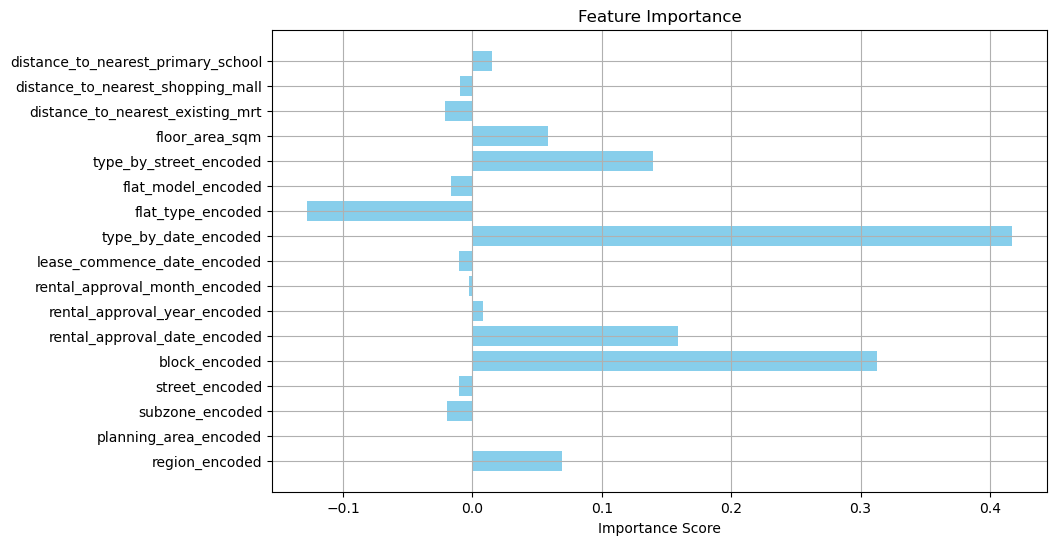

In [44]:
plt.figure(figsize=(10, 6))
plt.barh(FI_lasso.index, FI_lasso['Feature Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.grid(True)
plt.show()

### training

In [45]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

In [46]:
# train-test split

X_train, X_test, y_train, y_test = train_test_split(normalized_features, target_variable, test_size=0.33, random_state=42)

#### lasso regression model

In [47]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Lasso Regression with cross-validation
lasso = LassoCV(cv=kfold, random_state=42)
lasso.fit(X_train, y_train)

LassoCV(cv=KFold(n_splits=5, random_state=42, shuffle=True), random_state=42)

In [48]:
# evaluate the model

print("Optimal alpha:", lasso.alpha_)
print("Mean cross-validated score of the best estimator:", lasso.score(X_test, y_test))

Optimal alpha: 0.0006562409407921091
Mean cross-validated score of the best estimator: 0.5605662277876811


In [49]:
# making predictions 
y_pred = lasso.predict(X_test)

# evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f"Lasso Regression Mean Squared Error: {mse}")
print(f"Model Coefficients: \n{lasso.coef_}")

Lasso Regression Mean Squared Error: 0.4406857838889138
Model Coefficients: 
[ 0.07204814 -0.00120212 -0.02441907 -0.00312259  0.31457862  0.16104589
  0.01163763 -0.0019843  -0.00804206  0.4108467  -0.12786654 -0.01586773
  0.14141673  0.06044962 -0.0218949  -0.01064439  0.01445393]


#### graident boosting tree

In [50]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# implement gradient boosting tree with cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(gbr, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

gbr.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [51]:
mean_mse = np.mean(-cross_val_scores)
print(f"Gradient Boosting Regressor Mean Squared Error: {mean_mse}")

Gradient Boosting Regressor Mean Squared Error: 0.4017942876955939


In [52]:
print("Mean cross-validated score of the best regressor:", gbr.score(X_test, y_test))

Mean cross-validated score of the best regressor: 0.5964691620654212


### test set evaluation

In [53]:
test_set = pd.read_csv('Datasets/test.csv')

test_set.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region
0,2023-01,hougang,245,hougang street 22,5-room,improved,121.0,yes,1984,1.358411,103.891722,0.0,lorong ah soo,hougang,north-east region
1,2022-09,sembawang,316,sembawang vista,4-room,model a,100.0,yes,1999,1.446343,103.820817,0.0,sembawang central,sembawang,north region
2,2023-07,clementi,708,Clementi West Street 2,4-room,new generation,91.0,yes,1980,1.305719,103.762168,0.0,clementi west,clementi,west region
3,2021-08,jurong east,351,Jurong East Street 31,3 room,model a,74.0,yes,1986,1.344832,103.730778,0.0,yuhua west,jurong east,west region
4,2022-03,jurong east,305,jurong east street 32,5-room,improved,121.0,yes,1983,1.345437,103.735241,0.0,yuhua west,jurong east,west region


In [54]:
(test_set.isna().sum(axis=1) > 0).sum()

0

In [55]:
# data preparation

test_set[['rent_approval_year','rent_approval_month']] = test_set['rent_approval_date'].str.split('-',expand=True)

# test_set['rent_approval_date'] = test_set['rent_approval_date'].astype('Period[M]')

# street name to lower case
test_set['street_name'] = test_set['street_name'].apply(str.lower)

# replace blank space with hyphen in flat_type (e.g. '2 room' to '2-room')
test_set['flat_type'] = test_set['flat_type'].apply(lambda x: x.replace(' ', '-'))

# categorize lease commence date by decades (remember to date_filter_condition function above first)
test_set['lease_date_cat'] = test_set['lease_commence_date'].apply(date_filter_condition)

In [56]:
# merge auxiliary data
test_set = calculate_distance_to_facilities(test_set)
test_set.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,elevation,subzone,planning_area,region,rent_approval_year,rent_approval_month,lease_date_cat,distance_to_nearest_existing_mrt,distance_to_nearest_shopping_mall,distance_to_nearest_primary_school
0,2023-01,hougang,245,hougang street 22,5-room,improved,121.0,yes,1984,0.0,lorong ah soo,hougang,north-east region,2023,01,80s,0.820333,0.739403,0.149667
1,2022-09,sembawang,316,sembawang vista,4-room,model a,100.0,yes,1999,0.0,sembawang central,sembawang,north region,2022,09,90s,0.307784,0.254920,0.143325
2,2023-07,clementi,708,clementi west street 2,4-room,new generation,91.0,yes,1980,0.0,clementi west,clementi,west region,2023,07,80s,1.097689,0.497670,1.040844
3,2021-08,jurong east,351,jurong east street 31,3-room,model a,74.0,yes,1986,0.0,yuhua west,jurong east,west region,2021,08,80s,0.362810,1.596397,1.075525
4,2022-03,jurong east,305,jurong east street 32,5-room,improved,121.0,yes,1983,0.0,yuhua west,jurong east,west region,2022,03,80s,0.448980,1.461487,0.714777


In [57]:
# encoding test set

encoded_test_set = pd.DataFrame(index=test_set.index)

encoded_test_set['region_encoded'] = region_encoder.transform(test_set['region'])
encoded_test_set['planning_area_encoded'] = planning_area_encoder.transform(test_set['planning_area'])
encoded_test_set['subzone_encoded'] = subzone_encoder.transform(test_set['subzone'])
encoded_test_set['street_encoded'] = street_encoder.transform(test_set['street_name'])
encoded_test_set['block_encoded'] = block_encoder.transform(test_set['street_name']+test_set['block'])

encoded_test_set['rental_approval_date_encoded'] = rental_encoder.transform(test_set['rent_approval_date'])
encoded_test_set['rental_approval_year_encoded'] = rental_year_encoder.transform(test_set['rent_approval_year'])
encoded_test_set['rental_approval_month_encoded'] = rental_month_encoder.transform(test_set['rent_approval_month'])

encoded_test_set['lease_commence_date_encoded'] = lease_encoder.transform(test_set['lease_date_cat'])
encoded_test_set['type_by_date_encoded'] = type_by_date.transform(test_set['rent_approval_date']+test_set['flat_type'])

encoded_test_set['flat_type_encoded'] = flat_type_encoder.transform(test_set['flat_type'])
encoded_test_set['flat_model_encoded'] = flat_model_encoder.transform(test_set['flat_model'])
encoded_test_set['type_by_street_encoded'] = type_by_street.transform(test_set['street_name']+test_set['flat_type'])


encoded_test_set['floor_area_sqm'] = test_set['floor_area_sqm'].copy()

encoded_test_set['distance_to_nearest_existing_mrt'] = test_set['distance_to_nearest_existing_mrt'].copy()
encoded_test_set['distance_to_nearest_shopping_mall'] = test_set['distance_to_nearest_shopping_mall'].copy()
encoded_test_set['distance_to_nearest_primary_school'] = test_set['distance_to_nearest_primary_school'].copy()


In [58]:
encoded_test_set.head(10)

,region_encoded,planning_area_encoded,subzone_encoded,street_encoded,block_encoded,rental_approval_date_encoded,rental_approval_year_encoded,rental_approval_month_encoded,lease_commence_date_encoded,type_by_date_encoded,flat_type_encoded,flat_model_encoded,type_by_street_encoded,floor_area_sqm,distance_to_nearest_existing_mrt,distance_to_nearest_shopping_mall,distance_to_nearest_primary_school
0,2558.822710,2503.252886,2427.604167,2348.993316,2556.237503,3069.581639,3158.694858,2490.553580,2479.803864,3427.662037,2815.593875,2636.211052,2556.237503,121.0,0.820333,0.739403,0.149667
1,2450.623806,2540.491010,2592.332790,2640.043972,2509.793159,2812.587413,2651.014066,2489.108495,2700.899570,2924.288107,2692.359176,2612.031305,2614.003638,100.0,0.307784,0.254920,0.143325
2,2569.167537,2646.808979,2395.588235,2532.195122,2626.547123,3262.248898,3158.694858,2729.542350,2479.803864,3406.266491,2692.359176,2369.965462,2792.881615,91.0,1.097689,0.497670,1.040844
3,2569.167537,2595.146199,2400.150150,2780.896042,2540.333848,2249.901768,2225.773817,2470.895522,2479.803864,1988.479624,2276.033233,2612.031305,2565.461091,74.0,0.362810,1.596397,1.075525
4,2569.167537,2595.146199,2400.150150,2268.564360,2542.787517,2449.322430,2651.014066,2543.250298,2479.803864,2665.350877,2815.593875,2636.211052,2631.526100,121.0,0.448980,1.461487,0.714777
5,2569.167537,2646.808979,2395.588235,2229.881779,2629.794822,2351.327643,2651.014066,2490.553580,2479.803864,2085.797101,2276.033233,2369.965462,2176.899154,67.0,0.936153,0.696375,0.815124
6,2558.822710,2665.555556,2654.294479,2590.503432,2620.454030,2216.537301,2225.773817,2618.130520,2742.515391,2390.219224,2815.593875,2709.678998,2616.033755,110.0,1.741423,0.475512,0.334461
7,2570.667785,2638.489123,2602.085865,3081.579221,2730.005494,2755.309735,2651.014066,2470.895522,2742.515391,2985.820896,2815.593875,3150.404313,3224.684165,108.0,0.523289,0.419289,0.387834
8,2569.167537,2640.890551,2873.930481,2820.173278,2649.937911,2339.852217,2225.773817,2680.680614,2742.515391,2612.492565,2892.857143,2709.678998,2671.955887,133.0,0.316459,0.464394,0.247380
9,2737.201353,2585.947712,2585.947712,2480.479822,2808.073641,3262.248898,3158.694858,2729.542350,2421.705462,3611.022044,2815.593875,2444.223986,2781.188440,120.0,1.973240,1.061466,0.322340


In [59]:
# normalization

normalized_test_features = scaler.transform(encoded_test_set)

In [60]:
# lasso regressor prediction
lasso_y_pred = lasso.predict(normalized_test_features).reshape(-1, 1)
lasso_y_pred = y_scaler.inverse_transform(lasso_y_pred)

In [61]:
lasso_y_pred[:20]

array([[3169.49872881],
       [2660.21570296],
       [3447.25804036],
       [2132.25134339],
       [2526.07298406],
       [2242.69439036],
       [2284.17440124],
       [3234.11512858],
       [2577.1222796 ],
       [3878.49904987],
       [2062.55337703],
       [2863.49845543],
       [2779.27757499],
       [2687.82559035],
       [2350.0958965 ],
       [2754.63212135],
       [2060.46736397],
       [2627.57866206],
       [2483.04233349],
       [2811.7781502 ]])

In [62]:
df = pd.DataFrame(lasso_y_pred, columns=['Predicted'])
df.to_csv("predictions/updated_main_features_team18_lasso.csv", index_label="Id", header=True, float_format='%.4f')

In [63]:
# Gradient Boosting Regressor prediction
gbr_y_pred = gbr.predict(normalized_test_features).reshape(-1, 1)
gbr_y_pred = y_scaler.inverse_transform(gbr_y_pred)

In [64]:
gbr_y_pred[:20]

array([[2886.71674548],
       [2495.1654708 ],
       [3456.5604013 ],
       [2016.25979698],
       [2520.23411509],
       [2243.87263907],
       [2258.89480432],
       [3354.78835519],
       [2557.97609179],
       [4279.6502066 ],
       [2110.25695084],
       [2756.40516839],
       [2973.22359469],
       [2758.6464102 ],
       [2307.02950048],
       [2844.54687903],
       [2097.97909881],
       [2678.3330577 ],
       [2457.48009184],
       [2522.28286326]])

In [65]:
df = pd.DataFrame(gbr_y_pred, columns=['Predicted'])
df.to_csv("predictions/updated_main_features_team18_gbr.csv", index_label="Id", header=True, float_format='%.4f')

### XGBoost Regression

In [66]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [67]:
X, y = normalized_features, target_variable

In [68]:
# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [69]:
# Create regression matrices
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

#Printing basic information about the DMatrix
print("Number of training samples in DMatrix:", dtrain_reg.num_row())
print("Number of features in Dmatrix:", dtrain_reg.num_col())

Number of training samples in DMatrix: 45000
Number of features in Dmatrix: 17


In [70]:
# Define hyperparameters
params = {
    "objective": "reg:squarederror",
}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

In [71]:
feature_score = model.get_score(importance_type="gain")
print(feature_score)

{'f0': 2.704887866973877, 'f1': 2.894948720932007, 'f2': 1.6756854057312012, 'f3': 1.8568716049194336, 'f4': 25.544483184814453, 'f5': 4.027935028076172, 'f6': 7.189028263092041, 'f7': 1.2777165174484253, 'f8': 4.500386714935303, 'f9': 47.62873077392578, 'f10': 5.025144100189209, 'f11': 2.5963199138641357, 'f12': 4.8141937255859375, 'f13': 2.1805896759033203, 'f14': 1.7063002586364746, 'f15': 1.7689251899719238, 'f16': 1.5675339698791504}


In [72]:
preds = model.predict(dtest_reg)

In [73]:
# compute and print accuracy score

rmse = mean_squared_error(y_test, preds, squared=False)
r2 = r2_score(y_test, preds)

print(f"RMSE of the base model: {rmse:.3f}")
print(f"R2 score of the base model: {r2:.3f}")

RMSE of the base model: 0.649
R2 score of the base model: 0.578


#### Early stopping
We can test our model at each step and see if adding a new tree/round improves performance. To do so, we define a test dataset and a metric that is used to assess performance at each round. If performance haven’t improved for N rounds (N is defined by the variable early_stopping_round), we stop the training and keep the best number of boosting rounds.

In [74]:
params = {
    "objective": "reg:squarederror",
}
n = 100

# evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
evals = [(dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=2, # Every ten rounds
   early_stopping_rounds=10
)

[0]	validation-rmse:0.83666
[2]	validation-rmse:0.69238
[4]	validation-rmse:0.64932
[6]	validation-rmse:0.63763
[8]	validation-rmse:0.63393
[10]	validation-rmse:0.63275
[12]	validation-rmse:0.63221
[14]	validation-rmse:0.63253
[16]	validation-rmse:0.63268
[18]	validation-rmse:0.63269
[20]	validation-rmse:0.63283
[21]	validation-rmse:0.63311


#### XGBoost Cross Validation

In [75]:
params = {
    "objective": "reg:squarederror",
}
n = 100

results = xgb.cv(
   params, 
   dtrain_reg,
   num_boost_round=n,
   seed=42,
   nfold=5,
   metrics={'rmse'},
   early_stopping_rounds=20
)

In [76]:
best_rmse = results['test-rmse-mean'].min()
print(best_rmse)

0.6362644247537881


In [77]:
results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.838628,0.001113,0.841377,0.003411
1,0.742887,0.000406,0.748738,0.003719
2,0.688714,0.000770,0.697374,0.003444
3,0.658079,0.000828,0.669060,0.003449
4,0.640461,0.000662,0.653977,0.003612


#### Optimize XGBoost Model using GridSearch
GridSearch is a method used for hyperparameter tuning where one specifies a subset of possible values for each hyperparameter of interest. The method then exhaustively tries out all possible combinations of these hyperparameters to find the combination that produces the best model performance, according to some metric.

##### max_depth & min_child_weight

In [78]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(2,9)
    for min_child_weight in range(2,8)
]
num_boost_round = 100

In [79]:
# Define initial best params and MAE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))


CV with max_depth=2, min_child_weight=2
	RMSE 0.6377346117781846 for 99 rounds
CV with max_depth=2, min_child_weight=3
	RMSE 0.6379572862824312 for 99 rounds
CV with max_depth=2, min_child_weight=4
	RMSE 0.6376386010961842 for 99 rounds
CV with max_depth=2, min_child_weight=5
	RMSE 0.637600470161822 for 99 rounds
CV with max_depth=2, min_child_weight=6
	RMSE 0.6375800029312048 for 99 rounds
CV with max_depth=2, min_child_weight=7
	RMSE 0.6376485704588284 for 99 rounds
CV with max_depth=3, min_child_weight=2
	RMSE 0.6359919556600439 for 84 rounds
CV with max_depth=3, min_child_weight=3
	RMSE 0.6361694068000016 for 84 rounds
CV with max_depth=3, min_child_weight=4
	RMSE 0.6357233547522633 for 78 rounds
CV with max_depth=3, min_child_weight=5
	RMSE 0.6357925781323758 for 68 rounds
CV with max_depth=3, min_child_weight=6
	RMSE 0.6362122893576398 for 57 rounds
CV with max_depth=3, min_child_weight=7
	RMSE 0.6358844816401814 for 69 rounds
CV with max_depth=4, min_child_weight=2
	RMSE 0.63525

In [80]:
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

##### gamma

In [81]:
min_rmse = float("Inf")
best_params = None
for gamma in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]:
    print("CV with gamma={}".format(gamma))
    # We update our parameters
    params['gamma'] = gamma
    # Run and time CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['rmse'],
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = gamma
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with gamma=0.1
	RMSE 0.6347091982288167 for 28 rounds

CV with gamma=0.2
	RMSE 0.6347132126701693 for 34 rounds

CV with gamma=0.3
	RMSE 0.6347007608158107 for 34 rounds

CV with gamma=0.4
	RMSE 0.6347132403108745 for 34 rounds

CV with gamma=0.5
	RMSE 0.6347050027279119 for 34 rounds

CV with gamma=0.6
	RMSE 0.6346513073275791 for 34 rounds

Best params: 0.6, rmse: 0.6346513073275791


In [82]:
params['gamma'] = best_params

##### subsample & colsample

In [83]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [84]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	RMSE 0.6346513073275791 for 34 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 0.6360410749791512 for 29 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 0.6349996916969498 for 29 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 0.6353406030247942 for 27 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 0.6353100923750086 for 25 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 0.6358286841608712 for 25 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 0.6357488707719844 for 30 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 0.6357656166612704 for 31 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 0.6358144713600786 for 25 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 0.6360473678871899 for 29 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 0.6359433934875278 for 27 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 0.6361618049388348 for 26 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 0.6363452230729466 for 22 rounds
CV with subs

In [85]:
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

##### alpha & lumbda

In [86]:
gridsearch_params = {
    'reg_alpha': [0.05, 0.1, 1, 2, 3]
}

In [87]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for reg_alpha in gridsearch_params['reg_alpha']:
        print("CV with reg_alpha={}".format(
                                 reg_alpha))
        # We update our parameters
        params['reg_alpha'] = reg_alpha
        # Run CV
        cv_results = xgb.cv(
            params,
            dtrain_reg,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics={'rmse'},
            early_stopping_rounds=10
        )
        # Update best score
        mean_rmse = cv_results['test-rmse-mean'].min()
        boost_rounds = cv_results['test-rmse-mean'].argmin()
        print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
        if mean_rmse < min_rmse:
            min_rmse = mean_rmse
            best_params = reg_alpha
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with reg_alpha=0.05
	RMSE 0.634831083816749 for 64 rounds
CV with reg_alpha=0.1
	RMSE 0.6346908782698237 for 33 rounds
CV with reg_alpha=1
	RMSE 0.6353753247277958 for 28 rounds
CV with reg_alpha=2
	RMSE 0.6351206905729208 for 25 rounds
CV with reg_alpha=3
	RMSE 0.6347321546721878 for 33 rounds
Best params: 0.1, rmse: 0.6346908782698237


In [88]:
params['alpha'] = best_params

In [89]:
%time

min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    %time 
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['rmse'],
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CPU times: user 17 µs, sys: 2 µs, total: 19 µs
Wall time: 4.05 µs
CV with eta=0.3
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 3.1 µs
	RMSE 0.6347321546721878 for 33 rounds

CV with eta=0.2
CPU times: user 5 µs, sys: 6 µs, total: 11 µs
Wall time: 3.81 µs
	RMSE 0.6337415201511074 for 52 rounds

CV with eta=0.1
CPU times: user 1e+03 ns, sys: 9 µs, total: 10 µs
Wall time: 4.05 µs
	RMSE 0.6332238073491505 for 99 rounds

CV with eta=0.05
CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 4.05 µs
	RMSE 0.6348467214739432 for 99 rounds

CV with eta=0.01
CPU times: user 1e+03 ns, sys: 7 µs, total: 8 µs
Wall time: 4.05 µs
	RMSE 0.715059506268883 for 99 rounds

CV with eta=0.005
CPU times: user 4 µs, sys: 5 µs, total: 9 µs
Wall time: 4.05 µs
	RMSE 0.8068132032822202 for 99 rounds

Best params: 0.1, rmse: 0.6332238073491505


In [90]:
params['eta'] = best_params

In [91]:
params

{'objective': 'reg:squarederror',
 'max_depth': 4,
 'min_child_weight': 5,
 'gamma': 0.6,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'reg_alpha': 3,
 'alpha': 0.1,
 'eta': 0.1}

In [92]:
model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.94487
[1]	Test-rmse:0.89912
[2]	Test-rmse:0.85924
[3]	Test-rmse:0.82522
[4]	Test-rmse:0.79615
[5]	Test-rmse:0.77124
[6]	Test-rmse:0.75044
[7]	Test-rmse:0.73269
[8]	Test-rmse:0.71801
[9]	Test-rmse:0.70504
[10]	Test-rmse:0.69425
[11]	Test-rmse:0.68493
[12]	Test-rmse:0.67726
[13]	Test-rmse:0.67087
[14]	Test-rmse:0.66531
[15]	Test-rmse:0.66049
[16]	Test-rmse:0.65646
[17]	Test-rmse:0.65288
[18]	Test-rmse:0.65003
[19]	Test-rmse:0.64743
[20]	Test-rmse:0.64541
[21]	Test-rmse:0.64367
[22]	Test-rmse:0.64208
[23]	Test-rmse:0.64069
[24]	Test-rmse:0.63953
[25]	Test-rmse:0.63846
[26]	Test-rmse:0.63757
[27]	Test-rmse:0.63676
[28]	Test-rmse:0.63619
[29]	Test-rmse:0.63566
[30]	Test-rmse:0.63508
[31]	Test-rmse:0.63456
[32]	Test-rmse:0.63422
[33]	Test-rmse:0.63391
[34]	Test-rmse:0.63359
[35]	Test-rmse:0.63329
[36]	Test-rmse:0.63309
[37]	Test-rmse:0.63288
[38]	Test-rmse:0.63266
[39]	Test-rmse:0.63229
[40]	Test-rmse:0.63213
[41]	Test-rmse:0.63196
[42]	Test-rmse:0.63195
[43]	Test-rmse:0.6317

In [93]:
print("Best RMSE: {:.3f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 0.630 in 100 rounds


#### Saving the best model

In [94]:
dtrain = xgb.DMatrix(normalized_features, target_variable, enable_categorical=True)
dtest = xgb.DMatrix(normalized_test_features, enable_categorical=True)

In [95]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round
)

In [96]:
submission_test_pred = best_model.predict(dtest).reshape(-1, 1)
submission_test_pred = y_scaler.inverse_transform(submission_test_pred)

In [97]:
df = pd.DataFrame(submission_test_pred, columns=['Predicted'])
df.to_csv("predictions/updated_main_features_team18_xgb.csv", index_label="Id", header=True, float_format='%.4f')

In [98]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [99]:
# 定义一个交叉评估函数 Validation function
n_folds = 5
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(encoded_train_set.values)
    rmse= np.sqrt(-cross_val_score(model, normalized_features, target_variable, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [100]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.01, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6633 (0.0076)



In [101]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))   


Lasso score: 0.6605 (0.0076)



In [102]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

score = rmsle_cv(GBoost)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std())) 


Lasso score: 0.6336 (0.0077)



In [103]:
# XGBoost     
model_xgb = xgb.XGBRegressor(colsample_bytree=params['colsample_bytree'], gamma=params['gamma'], 
                             learning_rate=params['eta'], max_depth=params['max_depth'], 
                             min_child_weight=params['min_child_weight'], n_estimators=100)

score = rmsle_cv(model_xgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.6317 (0.0071)



In [104]:
# 堆叠模型(Stacking Averaged Models) 
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
        
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]  #  4×5 list 存放训练好的模型
        self.meta_model_ = clone(self.meta_model) # 复制基准模型，因为这里会有多个模型
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # 训练基准模型，基于基准模型训练的结果导出成特征
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y): #分为预测holdout_index和训练train_index
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # 将基准模型预测数据作为特征用来给meta_model训练
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
    
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [105]:
meta_model = lasso
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, model_xgb, lasso),
                                                 meta_model = meta_model,
                                                n_folds=10)
score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.6313 (0.0072)


In [106]:
stacked_averaged_models.fit(normalized_features,target_variable)
stacked_y_pred = stacked_averaged_models.predict(normalized_test_features).reshape(-1, 1)
stacked_y_pred = y_scaler.inverse_transform(stacked_y_pred)

In [107]:
stacked_y_pred[:20]

array([[2881.58546071],
       [2464.34892536],
       [3392.3129273 ],
       [2045.92520085],
       [2439.71813627],
       [2296.30572442],
       [2244.5831354 ],
       [3388.86029387],
       [2613.25792121],
       [4323.50695214],
       [2085.80938866],
       [2815.2718743 ],
       [3045.94134823],
       [2703.02749439],
       [2317.73806968],
       [2794.88142197],
       [2091.45971219],
       [2657.9734185 ],
       [2466.73371263],
       [2578.38211129]])

In [108]:
df = pd.DataFrame(stacked_y_pred, columns=['Predicted'])
df.to_csv("predictions/stack_team18.csv", index_label="Id", header=True, float_format='%.4f')